In [1]:
import pickle 
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from scipy.optimize import minimize
from IPython.display import display, Latex


In [2]:
d2metals = {
    '3': ['Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu'],
    '4': ['Nb', 'Mo', ],
    '5': ['W', ]
}

# for plotting
ele2col = {
    "Ti": "#808080",
    "V": "#ffcccb",
    "Cr": "k",
    "Mn": "#9b870c",
    "Fe": "r",
    "Co": "b",
    "Cu": "#FFFF00",
    "Nb": "cyan",
    "Mo": "#FFA500",
    "Sn": "k",
    "W": "fuchsia",
    "Ir": "b",
    "Ni": "#66FF00",
}

In [3]:
def plot_parabola(parabola):
    x = np.linspace(0, 4, 10)
    y = parabola[0]*x**2+parabola[1]*x
    plt.plot(x, y)
    
def formation_energy_mixing(ele1, ele2, concentrations, plotting=False):
    ox_quadratic_1 = mp_quadratic_equations_ox[ele1]
    ox_quadratic_2 = mp_quadratic_equations_ox[ele2]
    red_quadratic_1 = mp_quadratic_equations_red[ele2]
    red_quadratic_2 = mp_quadratic_equations_red[ele1]

    predicted_forms_1 = []
    predicted_forms_2 = []
    predicted_ox_change_1 = []
    predicted_ox_change_2 = []
    minima = []
    x_tots = []
    for conc in concentrations:
        
        o_1a, o_2a = ox_quadratic_1
        r_1a, r_2a = red_quadratic_1

        o_1b, o_2b = ox_quadratic_2
        r_1b, r_2b = red_quadratic_2
        if plotting:
            #print('checking {}'.format(conc))
            result_1 = minimize(oxidation_reduction_equation, 1, args=(conc, o_1a, o_2a, r_1a, r_2a, True), bounds=[(0, 10)])
            result_2 = minimize(oxidation_reduction_equation, 1, args=(1-conc, o_1b, o_2b, r_1b, r_2b, True), bounds=[(0, 10)])
            
        else:
            result_1 = minimize(oxidation_reduction_equation, 1, args=(conc, o_1a, o_2a, r_1a, r_2a),  bounds=[(0, 10)])
            # Note, the definition of concentration is different  between 1/2,
            # since it relates to the concentration of the element that is 
            # oxidisint or reducing.
            #handle this when plotting by flipping the x-axis horizontally
            result_2 = minimize(oxidation_reduction_equation, 1, args=(1-conc, o_1b, o_2b, r_1b, r_2b),  bounds=[(0, 10)])
        
        x_space = np.linspace(0, 3, 50)
        predicted_ox_change_1.append(result_1.x[0])
        # this can give problems depending on scipy version, might have to use result_1.fun
        predicted_forms_1.append(result_1.fun)
        predicted_ox_change_2.append(result_2.x[0])
        predicted_forms_2.append(result_2.fun)#result_2.fun[0] + diff*(1-conc))
        
        if plotting:
            mixed_1 = o_1a*(x_space**2)*(1-conc)**2+o_2a*x_space*(1-conc)+r_1a*(x_space**2)*conc**2+r_2a*x_space*conc
            ox1 = o_1a*x_space**2+o_2a*x_space
            red1 = r_1a*x_space**2+r_2a*x_space
            mixed_2 = o_1b*(x_space**2)*(conc)**2+o_2b*x_space*(conc)+(r_1b*((1-conc)*x_space)**2+r_2b*(1-conc)*x_space)
            ox2 = o_1b*x_space**2+o_2b*x_space
            red2 = r_1b*x_space**2+r_2b*x_space

            if min(mixed_1)<min(mixed_2):
                minima.append(min(mixed_1))
                x_tots.append(result_1.x[0])
                if conc not in [0, 1]:
                    plt.plot(x_space, mixed_1, label='mixed_{}{:.1f}{}{:.1f}'.format(ele1, 1-conc, ele2, conc), color='gray')
                    plt.plot(result_1.x[0], min(mixed_2), 'bo')
                if conc==0:
                    plt.plot(x_space, ox1, label=ele1+"_ox", color=ele2col[ele1[:-1]])
                    plt.plot(x_space, red1, label=ele2+"_red", color=ele2col[ele2[:-1]])
                if conc==1:
                    plt.legend(fontsize=13)
                    plt.xticks(fontsize=13)
                    plt.yticks(fontsize=13)
                    plt.savefig("{}_{}_mixing.pdf".format(ele1, ele2))
                    plt.show()
            else:
                minima.append(min(mixed_2))
                x_tots.append(result_2.x[0])
                if conc not in [0, 1]:
                    plt.plot(x_space, mixed_2, label='mixed_{}{:.2f}{}{:.2f}'.format(ele1, 1-conc, ele2, conc), )#color='gray')
                    plt.plot(result_2.x[0], min(mixed_2), 'bo')
                if conc==0:
                    plt.plot(x_space, ox2, label=ele2+"_ox", color=ele2col[ele2[:-1]])
                    plt.plot(x_space, red2, label=ele1+"_red", color=ele2col[ele1[:-1]])
                if conc==1:
                    plt.legend(fontsize=13)
                    plt.xticks(fontsize=13)
                    plt.yticks(fontsize=13)
                    plt.legend()
                    plt.savefig("{}_{}_mixing.pdf".format(ele1, ele2))
                    plt.show()
    
    if plotting:
        print("X_tots")
        for x in x_tots:
            print("{:.2f}".format(x), end=", ")
        print("\nΔ Cs")
        for x in minima:
            print("{:.2f}".format(x), end=", ")
        plt.plot(concentrations, minima)
        plt.plot([0, 1], [minima[0], minima[-1]], 'k--')
        plt.legend(fontsize=13)
        plt.xticks([0, 0.25, 0.5, 0.75, 1], fontsize=13)
        plt.yticks(fontsize=13)
        
        plt.savefig("deltaC_1c.pdf")
        plt.show()

        ox2 = o_1b*x_space**2+o_2b*x_space
        red2 = r_1b*x_space**2+r_2b*x_space
        plt.plot(x_space, ox2, label=ele2[:-1], color=ele2col[ele2[:-1]])
        plt.plot(x_space, red2, label=ele1[:-1], color=ele2col[ele1[:-1]])
        plt.ylim(top=1)
        plt.legend(fontsize=13)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.savefig("indiv_parabolas_1a.pdf")
        plt.show()
        
    xs_1 = []
    xs_2 = []
    for conc in concentrations:
        # need to shift the energies so that either end is set to 0
        # so shift every point proportionally
        xs_1.append(predicted_forms_1[0]*(1-conc)+predicted_forms_1[-1]*(conc))
        xs_2.append(predicted_forms_2[0]*(1-conc)+predicted_forms_2[-1]*(conc))
        
    return np.array(predicted_forms_1)-xs_1, np.array(predicted_forms_2)-xs_2, predicted_ox_change_1, predicted_ox_change_2

def oxidation_reduction_equation(x, ox_conc, o1, o2, r1, r2, plot=False):
    """
    Defines the equation to optimize oxidation state when mixed
    Args:
    x: The amount of oxidation state change
    ox_conc: The concentration of the oxidising element between 0 and 1
    o1, o2, o3: Define the quadratic equation for the oxidising element
    r1, r2, r3: Define the quadratic equation for the reducing element
    """
    return (o1*x**2*(1-ox_conc)**2+o2*x*(1-ox_conc))+(r1*(ox_conc*x)**2+r2*(ox_conc*x))


def find_nearest(array, value):
    """
    Helper function to find the closest conc
    """
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx


In [4]:
mo_parabs = pd.read_csv("supplementary_data/MO_parabs.csv", index_col=0)
m2o3_parabs = pd.read_csv("supplementary_data/M2O3_parabs.csv", index_col=0)
mo2_parabs = pd.read_csv("supplementary_data/MO2_parabs.csv", index_col=0)

mp_quadratic_equations_ox = defaultdict()
mp_quadratic_equations_red = defaultdict()

for ele in mo_parabs.index:
    mp_quadratic_equations_ox[ele+"2"] = (mo_parabs.loc[ele]["oxidising a1"], mo_parabs.loc[ele]["oxidising a2"])
    mp_quadratic_equations_red[ele+"2"] = (mo_parabs.loc[ele]["reducing a1"], mo_parabs.loc[ele]["reducing a2"])
    
for ele in m2o3_parabs.index:
    mp_quadratic_equations_ox[ele+"3"] = (m2o3_parabs.loc[ele]["oxidising a1"], m2o3_parabs.loc[ele]["oxidising a2"])
    mp_quadratic_equations_red[ele+"3"] = (m2o3_parabs.loc[ele]["reducing a1"], m2o3_parabs.loc[ele]["reducing a2"])
    
for ele in mo2_parabs.index:
    mp_quadratic_equations_ox[ele+"4"] = (mo2_parabs.loc[ele]["oxidising a1"], mo2_parabs.loc[ele]["oxidising a2"])
    mp_quadratic_equations_red[ele+"4"] = (mo2_parabs.loc[ele]["reducing a1"], mo2_parabs.loc[ele]["reducing a2"])


In [5]:
binary_pairing_data = pickle.load(open('data_gather/binary_pairing_data.p', 'rb'))

# iterate over these eqs, removing the oxidation number label to get all the elements 
set_of_elements = set([x[:-1] for x in mp_quadratic_equations_ox])
# these give issues in that they cause a bug where the code finds or Ir Yb entries 
# when it shouldn't. I gets mistakenly matched with Ir data, and Y with Yb data.
set_of_elements.remove("I")
set_of_elements.remove("Y")


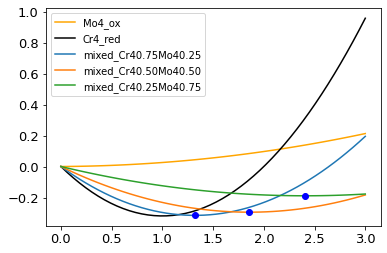

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


X_tots
1.00, 1.32, 1.86, 2.41, 0.00, 
Δ Cs
-0.32, -0.32, -0.29, -0.19, 0.00, 

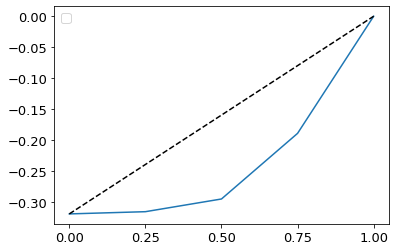

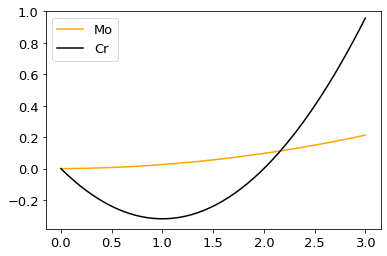

[ 0.         -0.07614592 -0.1353149  -0.10919192  0.        ]


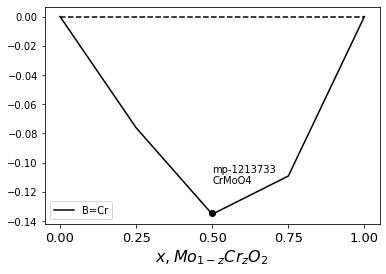

In [6]:
oxidation_state = 4
for housing_element in ['Mo']:
    house_ele_ox = housing_element+str(oxidation_state)
    #print(house_ele_ox)
    if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
        print("Missing eq for {}".format(housing_element))
        continue
    
    pairings = []
    ground_states =  []
    zs = [0, 0.25, 0.5, 0.75, 1.0]

    for ele in ['Cr']:

        dope_ele_ox = ele+str(oxidation_state)
        if ele==housing_element:
            continue

        else: 
            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, plotting=True)

        can_reduce = True
        can_oxidise = True
        # check if it found any solutions 
        if sum(ox_1)==0:
            can_reduce = False
        if sum(ox_2)==0:
            can_oxidise = False 
            
        if can_reduce:
            plt.plot(zs, pred_1, label="B={}".format(ele), color=ele2col[ele])
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
            print(pred_1)
        if can_oxidise:
            plt.plot(zs, pred_2, label="B={}".format(ele), ls='-', color=ele2col[ele])#, 'r-')
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
            print(pred_2)
        
        if ele<housing_element:
            info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(oxidation_state)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                        plt.text(conc2plot, info_dict[match]['MP ΔD']+0.02, 
                                 info_dict[match]['MP_id']+"\n"+info_dict[match]['MP_name'])

                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                        plt.text(conc2plot, info_dict[match]['MP ΔD']+0.02, 
                                 info_dict[match]['MP_id']+"\n"+info_dict[match]['MP_name'])
        else:
            info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(oxidation_state)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                        plt.text(conc2plot, info_dict[match]['MP ΔD']+0.02, 
                                 info_dict[match]['MP_id']+"\n"+info_dict[match]['MP_name'])
                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                        plt.text(conc2plot, info_dict[match]['MP ΔD']+0.02, 
                                 info_dict[match]['MP_id']+"\n"+info_dict[match]['MP_name'])
                        
    plt.xticks([0, 0.25, 0.5, 0.75, 1], fontsize=13)
    plt.legend()
    plt.xlabel("$x, {}_{{1-z}}Cr_{{z}}O_{{2}}$".format(housing_element, ), fontsize=16)
    plt.savefig("Cr_Mo_1d.pdf")
        

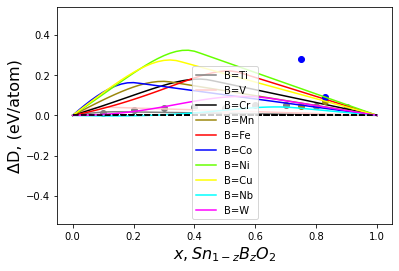

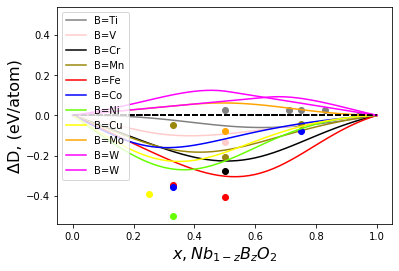

In [7]:
oxidation_state = 4
for housing_element in ['Sn', 'Nb']:
    house_ele_ox = housing_element+str(oxidation_state)
    #print(house_ele_ox)
    if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
        print("Missing eq for {}".format(housing_element))
        continue
    
    pairings = []
    ground_states =  []
    zs = np.linspace(0, 1.00, 51)

    for ele in d2metals['3']+d2metals['4']+d2metals['5']:
        #print(ele)
        dope_ele_ox = ele+str(oxidation_state)
        if ele==housing_element:
            continue

        else: 
            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, )

        can_reduce = True
        can_oxidise = True
        # check if it found any solutions 
        if sum(ox_1)==0:
            can_reduce = False
        if sum(ox_2)==0:
            can_oxidise = False 
            
        if can_reduce:
            plt.plot(zs, pred_1, label="B={}".format(ele), color=ele2col[ele])
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
        if can_oxidise:
            plt.plot(zs, pred_2, label="B={}".format(ele), ls='-', color=ele2col[ele])#, 'r-')
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
        
        if ele<housing_element:
            info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(oxidation_state)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
        else:
            info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(oxidation_state)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])

        
    plt.legend()
    plt.xlabel("$x, {}_{{1-z}}B_{{z}}O_{{2}}$".format(housing_element, ), fontsize=16)
    plt.ylabel("ΔD, (eV/atom)", fontsize=16)
    plt.ylim(-0.54, 0.54)
    plt.savefig("{}_higherdmixing.pdf".format(housing_element))
    plt.show()
        
        

Checking oxides of type as below


<IPython.core.display.Latex object>

total matches: 777
MAE for unfiltered: 0.236
total matches with good geom: 232
MAE for filtered: 0.127


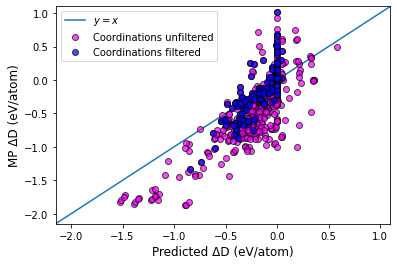

Checking oxides of type as below


<IPython.core.display.Latex object>

total matches: 1369
MAE for unfiltered: 0.249
total matches with good geom: 176
MAE for filtered: 0.118


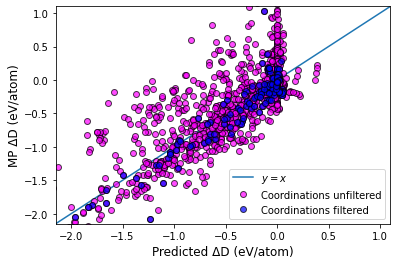

Checking oxides of type as below


<IPython.core.display.Latex object>

total matches: 932
MAE for unfiltered: 0.122
total matches with good geom: 298
MAE for filtered: 0.096


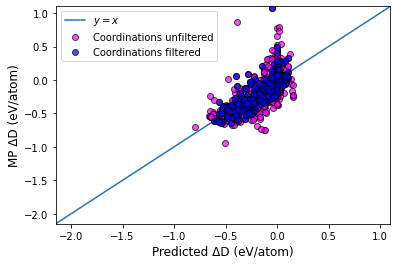

In [8]:
ox2oxide_type = {
    "2": "$A_{1-z}B_{z}O$",
    "3": "$A_{1-z}B_{z}O_{1.5}$",
    "4": "$A_{1-z}B_{z}O_{2}$"
}
maes = []
num_oxides = []

good_maes = []
num_good_oxides = []
# dictionary mapping oxidation state to x/y plot for all oxides 
ox2xs = defaultdict()
ox2ys = defaultdict()
# dictionary mapping oxidation state to x/y plot for oxides conditioned on geometry
ox2good_xs = defaultdict()
ox2good_ys = defaultdict()

# dictionary mapping oxidation state to form ene x/y plot for all oxides 
ox2pred_form_enes = defaultdict()
ox2mp_form_enes = defaultdict()
ox2weighted_avgs = defaultdict()
# dictionary mapping oxidation state to form ene x/y plot for oxides conditioned on geometry
ox2good_pred_form_enes = defaultdict()
ox2good_mp_form_enes = defaultdict()
ox2good_weighted_avgs = defaultdict()


for oxidation_state in [2, 3, 4]:
    print("Checking oxides of type as below")
    display(Latex(ox2oxide_type[str(oxidation_state)]))
    data_dict = defaultdict()
    seen_combinations = []
    lower_lim = -2.15
    upper_lim = 1.1
    for housing_element in set_of_elements:
        house_ele_ox = housing_element+str(oxidation_state)
        if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
            print("Missing eq for {}".format(housing_element))
            continue

        pairings = []
        ground_states =  []
        zs = np.linspace(0, 1.00, 51)

        for ele in set_of_elements:
            dope_ele_ox = ele+str(oxidation_state)
            if housing_element+ele in seen_combinations or ele+housing_element in seen_combinations or ele==housing_element:
                continue
            else:
                seen_combinations.append(ele+housing_element)
            if ele<housing_element:
                info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(int(oxidation_state))]
            else:
                info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(int(oxidation_state))]
            if len(info_dict)==0:
                continue

            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, )
            for ele_conc in info_dict:
                conc = float(ele_conc.split("_")[1])
                #closest_idx = find_nearest(zs, conc)
                if ele+"_{:.2f}".format(conc)==ele_conc:# in info_dict.keys():
                    # the 'element' variable is the one with that conc
                    # the ele conc is the one we get a ΔD value for at 
                    # given conc, and this has to match the way
                    # the weighted average was calculated
                    # this key will be accessed later
                    inner_key = ele+housing_element+"{:.2f}".format(conc)
                    closest_idx = find_nearest(zs, conc)

                elif housing_element+"_{:.2f}".format(conc)==ele_conc:
                    # the 'housing_element' is the one with that conc
                    inner_key = housing_element+ele+"{:.2f}".format(conc)
                    # since the ΔD is calculated for ele conc, need to switch 
                    # to the other side of the diagram
                    closest_idx = find_nearest(zs, 1-conc)
                    
                if pred_2[closest_idx]<pred_1[closest_idx]:
                    ox_change = ox_2[closest_idx]
                else:
                    ox_change = ox_1[closest_idx]

                data_dict[inner_key] = {
                    "predicted ΔD": min(pred_2[closest_idx], pred_1[closest_idx]),
                    "true ΔD": info_dict[ele_conc]['MP ΔD'],
                    "predicted formation energy": min(pred_2[closest_idx], pred_1[closest_idx]) + info_dict[ele_conc]['MP weighted average'],
                    "true formation energy": info_dict[ele_conc]['MP weighted average']+info_dict[ele_conc]['MP ΔD'],
                    "weighted average of refs": info_dict[ele_conc]['MP weighted average'],
                    "coordination_match": info_dict[ele_conc]['Coordination match'],
                    "x_tot": ox_change,
                    "mp_id": info_dict[ele_conc]['MP_id'],
                    "mp_name": info_dict[ele_conc]['MP_name'],
                    "motifs": info_dict[ele_conc]['motifs'],
                }
                
    plt.plot([lower_lim, upper_lim], [lower_lim, upper_lim], label='$y=x$')
    xs = []
    ys = []
    pred_form_enes = []
    mp_form_enes = []
    weighted_avgs = []
    for key, val in data_dict.items():
        xs.append(val['predicted ΔD'])
        ys.append(val['true ΔD'])
        
        pred_form_enes.append(val['predicted formation energy'])
        mp_form_enes.append(val['true formation energy'])
        weighted_avgs.append(val['weighted average of refs'])
    print("total matches: {}".format(len(xs)))
    plt.plot(xs, ys, 'o', color='fuchsia', alpha=0.7, label='Coordinations unfiltered', markeredgecolor='k')
    print("MAE for unfiltered: {:.3f}".format(np.mean(abs(np.array(xs)-np.array(ys)))))
    plt.xlabel("Predicted ΔD (eV/atom)", fontsize=12)
    plt.ylabel("MP ΔD (eV/atom)", fontsize=12)
    maes.append(np.mean(abs(np.array(xs)-np.array(ys))))
    num_oxides.append(len(xs))
    ox2xs[oxidation_state] = xs
    ox2ys[oxidation_state] = ys
    ox2pred_form_enes[oxidation_state] = pred_form_enes
    ox2mp_form_enes[oxidation_state] = mp_form_enes
    ox2weighted_avgs[oxidation_state] = weighted_avgs

    xs = []
    ys = []
    pred_form_enes = []
    mp_form_enes = []
    weighted_avgs = []
    for key, val in data_dict.items():
        if not val['coordination_match']:
            # bad geometry, skip
            continue
        xs.append(val['predicted ΔD'])
        ys.append(val['true ΔD'])
        
        pred_form_enes.append(val['predicted formation energy'])
        mp_form_enes.append(val['true formation energy'])
        weighted_avgs.append(val['weighted average of refs'])
#         if abs(xs[-1]-ys[-1])>0.5:
#             plt.text(xs[-1], ys[-1], "{}".format(key))

    ox2good_xs[oxidation_state] = xs
    ox2good_ys[oxidation_state] = ys
    ox2good_pred_form_enes[oxidation_state] = pred_form_enes
    ox2good_mp_form_enes[oxidation_state] = mp_form_enes
    ox2good_weighted_avgs[oxidation_state] = weighted_avgs
    print("total matches with good geom: {}".format(len(xs)))
    plt.plot(xs, ys, 'o', color='b', alpha=0.7, label='Coordinations filtered', markeredgecolor='k')
    print("MAE for filtered: {:.3f}".format(np.mean(abs(np.array(xs)-np.array(ys)))))
    plt.xlim(lower_lim, upper_lim)
    plt.ylim(lower_lim, upper_lim)
    plt.legend()
    plt.xlabel("Predicted ΔD (eV/atom)", fontsize=12)
    plt.ylabel("MP ΔD (eV/atom)", fontsize=12)
    plt.savefig("parities_ox_state_{}.pdf".format(oxidation_state))
    plt.show()
    good_maes.append(np.mean(abs(np.array(xs)-np.array(ys))))
    num_good_oxides.append(len(xs))


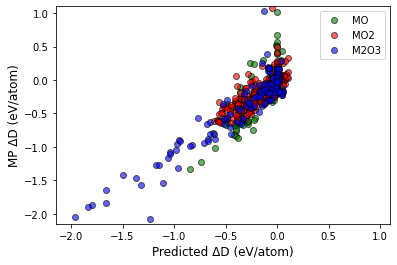

In [9]:
plt.plot(ox2good_xs[2], ox2good_ys[2], 'o', color='g', alpha=0.6, label='MO', markeredgecolor='k')
plt.plot(ox2good_xs[4], ox2good_ys[4], 'o', color='r', alpha=0.6, label='MO2', markeredgecolor='k')
plt.plot(ox2good_xs[3], ox2good_ys[3], 'o', color='b', alpha=0.6, label='M2O3', markeredgecolor='k')
plt.xlim(lower_lim, upper_lim)
plt.ylim(lower_lim, upper_lim)
plt.legend()
plt.xlabel("Predicted ΔD (eV/atom)", fontsize=12)
plt.ylabel("MP ΔD (eV/atom)", fontsize=12)
plt.savefig("parity_filtered_all.pdf")


Text(0, 0.5, 'MP Δ$E_{f}$ (eV/atom)')

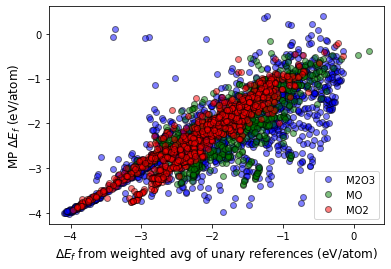

In [10]:
plt.plot(ox2weighted_avgs[3], ox2mp_form_enes[3], 'o', color='b', alpha=0.5, label='M2O3', markeredgecolor='k')
plt.plot(ox2weighted_avgs[2], ox2mp_form_enes[2], 'o', color='g', alpha=0.5, label='MO', markeredgecolor='k')
plt.plot(ox2weighted_avgs[4], ox2mp_form_enes[4], 'o', color='r', alpha=0.5, label='MO2', markeredgecolor='k')
#plt.xlim(-4.2, 0.6)
#plt.ylim(-4.2, 0.6)
plt.legend()
plt.xlabel("Δ$E_{f}$ from weighted avg of unary references (eV/atom)", fontsize=12)
plt.ylabel("MP Δ$E_{f}$ (eV/atom)", fontsize=12)
#plt.savefig("parity_form_ene_no_filter.pdf")

Text(0, 0.5, 'MP Δ$E_{f}$ (eV/atom)')

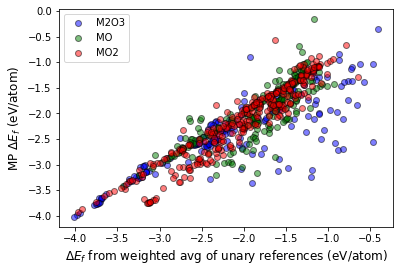

In [11]:
plt.plot(ox2good_weighted_avgs[3], ox2good_mp_form_enes[3], 'o', color='b', alpha=0.5, label='M2O3', markeredgecolor='k')
plt.plot(ox2good_weighted_avgs[2], ox2good_mp_form_enes[2], 'o', color='g', alpha=0.5, label='MO', markeredgecolor='k')
plt.plot(ox2good_weighted_avgs[4], ox2good_mp_form_enes[4], 'o', color='r', alpha=0.5, label='MO2', markeredgecolor='k')
#plt.xlim(-4.2, 0.6)
#plt.ylim(-4.2, 0.6)
plt.legend()
plt.xlabel("Δ$E_{f}$ from weighted avg of unary references (eV/atom)", fontsize=12)
plt.ylabel("MP Δ$E_{f}$ (eV/atom)", fontsize=12)
#plt.savefig("parity_form_ene_no_filter.pdf")

MAE for M2O3: 0.249
MAE for MO: 0.236
MAE for MO2: 0.122


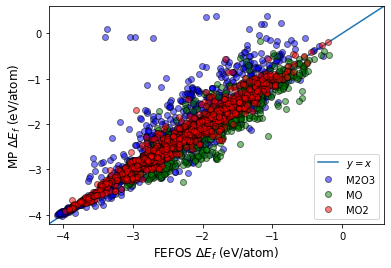

In [12]:
plt.plot([-4.2, 0.6], [-4.2, 0.6], label='$y=x$')
plt.plot(ox2pred_form_enes[3], ox2mp_form_enes[3], 'o', color='b', alpha=0.5, label='M2O3', markeredgecolor='k')
print("MAE for M2O3: {:.3f}".format(np.mean(abs(np.array(ox2pred_form_enes[3])-np.array(ox2mp_form_enes[3])))))
plt.plot(ox2pred_form_enes[2], ox2mp_form_enes[2], 'o', color='g', alpha=0.5, label='MO', markeredgecolor='k')
print("MAE for MO: {:.3f}".format(np.mean(abs(np.array(ox2pred_form_enes[2])-np.array(ox2mp_form_enes[2])))))
plt.plot(ox2pred_form_enes[4], ox2mp_form_enes[4], 'o', color='r', alpha=0.5, label='MO2', markeredgecolor='k')
print("MAE for MO2: {:.3f}".format(np.mean(abs(np.array(ox2pred_form_enes[4])-np.array(ox2mp_form_enes[4])))))
plt.xlim(-4.2, 0.6)
plt.ylim(-4.2, 0.6)
plt.legend()
plt.xlabel("FEFOS Δ$E_{f}$ (eV/atom)", fontsize=12)
plt.ylabel("MP Δ$E_{f}$ (eV/atom)", fontsize=12)
plt.savefig("parity_form_ene_no_filter.pdf")

MAE for MO-type: 0.127
MAE for MO2-type: 0.096
MAE for M2O3-type: 0.118


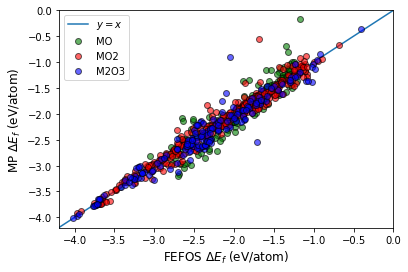

In [13]:
plt.plot([-4.2, 0.6], [-4.2, 0.6], label='$y=x$')
plt.plot(ox2good_pred_form_enes[2], ox2good_mp_form_enes[2], 'o', color='g', alpha=0.6, label='MO', markeredgecolor='k')
print("MAE for MO-type: {:.3f}".format(np.mean(abs(np.array(ox2good_pred_form_enes[2])-np.array(ox2good_mp_form_enes[2])))))
plt.plot(ox2good_pred_form_enes[4], ox2good_mp_form_enes[4], 'o', color='r', alpha=0.6, label='MO2', markeredgecolor='k')
print("MAE for MO2-type: {:.3f}".format(np.mean(abs(np.array(ox2good_pred_form_enes[4])-np.array(ox2good_mp_form_enes[4])))))
plt.plot(ox2good_pred_form_enes[3], ox2good_mp_form_enes[3], 'o', color='b', alpha=0.6, label='M2O3', markeredgecolor='k')
print("MAE for M2O3-type: {:.3f}".format(np.mean(abs(np.array(ox2good_pred_form_enes[3])-np.array(ox2good_mp_form_enes[3])))))
plt.xlim(-4.2, 0.0)
plt.ylim(-4.2, 0.0)
plt.legend()
plt.xlabel("FEFOS Δ$E_{f}$ (eV/atom)", fontsize=12)
plt.ylabel("MP Δ$E_{f}$ (eV/atom)", fontsize=12)
plt.savefig("parity_form_ene_filter.pdf")


In [14]:
total_oxides = sum(num_oxides)
unfiltered_avg = 0
for num_ox, mae in zip(num_oxides, maes):
    unfiltered_avg+=num_ox*mae*(1.0/total_oxides)
print("Total MAE for unfiltered: {:.3f} eV/atom".format(unfiltered_avg))
total_oxides = sum(num_good_oxides)
filtered_avg = 0
for num_ox, mae in zip(num_good_oxides, good_maes):
    filtered_avg+=num_ox*mae*(1.0/total_oxides)
print("Total MAE for filtered: {:.3f} eV/atom".format(filtered_avg))


Total MAE for unfiltered: 0.207 eV/atom
Total MAE for filtered: 0.112 eV/atom


### Printing for spreadsheet

In [15]:
ox2oxide_type = {
    "2": "$A_{1-z}B_{z}O$",
    "3": "$A_{1-z}B_{z}O_{1.5}$",
    "4": "$A_{1-z}B_{z}O_{2}$"
}
for oxidation_state in [2, 3, 4]:
    print("Checking oxides of type as below")
    display(Latex(ox2oxide_type[str(oxidation_state)]))
    data_dict = defaultdict()
    seen_combinations = []

    for housing_element in set_of_elements:
        house_ele_ox = housing_element+str(oxidation_state)
        if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
            print("Missing eq for {}".format(housing_element))
            continue

        pairings = []
        ground_states =  []
        zs = np.linspace(0, 1.00, 51)

        for ele in set_of_elements:
            dope_ele_ox = ele+str(oxidation_state)
            if housing_element+ele in seen_combinations or ele+housing_element in seen_combinations or ele==housing_element:
                continue
            else:
                seen_combinations.append(ele+housing_element)
            if ele<housing_element:
                info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(int(oxidation_state))]
            else:
                info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(int(oxidation_state))]
            if len(info_dict)==0:
                continue

            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, )
            for ele_conc in info_dict:
                conc = float(ele_conc.split("_")[1])
                #closest_idx = find_nearest(zs, conc)
                if ele+"_{:.2f}".format(conc)==ele_conc:# in info_dict.keys():
                    # the 'element' variable is the one with that conc
                    # the ele conc is the one we get a ΔD value for at 
                    # given conc, and this has to match the way
                    # the weighted average was calculated
                    # this key will be accessed later
                    inner_key = ele+housing_element+"{:.2f}".format(conc)
                    closest_idx = find_nearest(zs, conc)

                elif housing_element+"_{:.2f}".format(conc)==ele_conc:
                    # the 'housing_element' is the one with that conc
                    inner_key = housing_element+ele+"{:.2f}".format(conc)
                    # since the ΔD is calculated for ele conc, need to switch 
                    # to the other side of the diagram
                    closest_idx = find_nearest(zs, 1-conc)
                    
                if pred_2[closest_idx]<pred_1[closest_idx]:
                    ox_change = ox_2[closest_idx]
                else:
                    ox_change = ox_1[closest_idx]

                data_dict[inner_key] = {
                    "predicted ΔD": min(pred_2[closest_idx], pred_1[closest_idx]),
                    "true ΔD": info_dict[ele_conc]['MP ΔD'],
                    "predicted formation energy": min(pred_2[closest_idx], pred_1[closest_idx]) + info_dict[ele_conc]['MP weighted average'],
                    "true formation energy": info_dict[ele_conc]['MP weighted average']+info_dict[ele_conc]['MP ΔD'],
                    "weighted average of refs": info_dict[ele_conc]['MP weighted average'],
                    "coordination_match": info_dict[ele_conc]['Coordination match'],
                    "x_tot": ox_change,
                    "mp_id": info_dict[ele_conc]['MP_id'],
                    "mp_name": info_dict[ele_conc]['MP_name'],
                    "motifs": info_dict[ele_conc]['motifs'],
                }
                print(data_dict[inner_key]['mp_name'], end=", ")
                print(data_dict[inner_key]['mp_id'], end=", ")
                print("{:.4f}".format(data_dict[inner_key]['true formation energy']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['predicted formation energy']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['true ΔD']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['predicted ΔD']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['weighted average of refs']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['x_tot']), end=", ")
                print(data_dict[inner_key]['coordination_match'], end=", ")
                motifs2print = ""
                for motif in data_dict[inner_key]['motifs']:
                    motifs2print+=motif+"/"
                motifs2print = motifs2print[:-1]
                print(motifs2print)




Checking oxides of type as below


<IPython.core.display.Latex object>

Li3TaO4, mp-3151, -2.8501, -2.3618, -1.2226, -0.7343, -1.6275, 3.9729, True, octahedral/unrecognized
TaMn2O3, mp-31900, -1.3168, -1.8745, 0.4119, -0.1458, -1.7287, 0.1350, False, unrecognized
LiGdO2, mp-21332, -3.2128, -2.9775, -0.8157, -0.5804, -2.3971, 1.9999, False, octahedral/unrecognized
LiZnO2, mp-760408, -1.6398, -1.7751, 0.1353, -0.0000, -1.7751, 0.0000, True, octahedral
RbLi2O3, mp-1095542, -1.1111, -1.7984, 0.5100, -0.1773, -1.6211, 2.6900, False, unrecognized
Li4TeO5, mp-4804, -2.1057, -1.8766, -0.6382, -0.4091, -1.4675, 2.6474, True, octahedral/unrecognized/square pyramidal
Li2TeO3, mp-27231, -2.0203, -1.8588, -0.7480, -0.5865, -1.2723, 2.9742, False, unrecognized
Li2CeO3, mp-754534, -2.9985, -2.6675, -0.7473, -0.4163, -2.2511, 2.5026, False, octahedral/unrecognized
LiCeO2, mp-8412, -3.0893, -2.9492, -0.5927, -0.4526, -2.4966, 2.5747, False, unrecognized
Li2GeO3, mp-15349, -2.3220, -2.0558, -0.8023, -0.5361, -1.5197, 2.9786, False, tetrahedral/unrecognized
Li3GeO4, mp-12113

Li4WO5, mp-555377, -2.3727, -2.0853, -0.6735, -0.3861, -1.6992, 4.9988, True, octahedral/unrecognized/square pyramidal
LiWO2, mp-25467, -1.7481, -1.7666, -0.1402, -0.1587, -1.6079, 2.7878, True, octahedral
LiYbO2, mp-8390, -2.4746, -2.6942, 0.2196, -0.0000, -2.6942, 0.0000, True, octahedral
LiRhO2, mp-14115, -1.5656, -1.5419, -0.3789, -0.3553, -1.1866, 2.6747, True, octahedral
Li2RhO3, mp-754870, -1.7476, -1.7777, -0.3698, -0.3999, -1.3778, 2.9964, True, octahedral
LiInO2, mp-5488, -2.0622, -2.0283, -0.5052, -0.4713, -1.5570, 1.9999, False, octahedral/unrecognized
Li2SiO3, mp-5012, -2.8822, -2.4687, -1.0264, -0.6129, -1.8558, 3.0121, False, tetrahedral/unrecognized
LiMg3O4, mp-1099259, -2.6481, -2.7304, 0.0822, -0.0000, -2.7304, 0.0000, True, octahedral
Li2HfO3, mp-755352, -3.1669, -2.6897, -1.3237, -0.8465, -1.8432, 2.9626, True, octahedral/unrecognized
LiTiO2, mp-38280, -2.9784, -2.6813, -0.6448, -0.3476, -2.3337, 2.6604, True, octahedral
Li5Ti3O8, mp-756645, -2.9579, -2.5935, -0.767

ZnWO2, mvc-1291, -1.1322, -1.6228, 0.4906, 0.0000, -1.6228, 0.0000, False, octahedral/unrecognized
MgZn4O5, mp-1221986, -2.0198, -2.0427, 0.0230, 0.0000, -2.0427, 0.0000, False, tetrahedral
MgZnO2, mp-1221905, -2.3918, -2.4219, 0.0301, 0.0000, -2.4219, 0.0000, False, tetrahedral
Mg3ZnO4, mp-753315, -2.7050, -2.7378, 0.0329, 0.0000, -2.7378, 0.0000, True, octahedral
MgZn7O8, mp-1210610, -1.9418, -1.9480, 0.0062, 0.0000, -1.9480, 0.0000, False, tetrahedral
MgZn2O3, mp-1221931, -2.1156, -2.2112, 0.0957, 0.0000, -2.2112, 0.0000, True, octahedral
Mg2ZnO3, mp-1222123, -2.5854, -2.6325, 0.0471, 0.0000, -2.6325, 0.0000, True, octahedral
MgZn3O4, mp-1221958, -2.0927, -2.1059, 0.0132, 0.0000, -2.1059, 0.0000, False, tetrahedral
BaZnO2, mp-4236, -2.3645, -2.3063, -0.0582, 0.0000, -2.3063, 0.0000, False, tetrahedral/unrecognized
Ba2ZnO3, mp-17911, -2.5333, -2.4784, -0.0549, 0.0000, -2.4784, 0.0000, False, tetrahedral/unrecognized
TiZnO2, mvc-12201, -2.4450, -2.3486, -0.0964, 0.0000, -2.3486, 0.000

CdAgO2, mp-996963, -0.8838, -0.9081, 0.0243, 0.0000, -0.9081, 0.0000, False, octahedral/unrecognized
CdPt3O4, mp-1213850, -0.8071, -0.7806, -0.0266, 0.0000, -0.7806, 0.0000, False, bcc/unrecognized
CeGeO2, mp-1213932, -2.1828, -1.9028, -0.0469, 0.2331, -2.1360, 1.3227, False, octahedral/unrecognized
NaCeO2, mp-1101668, -2.9708, -2.6858, -0.6429, -0.3579, -2.3280, 3.1129, False, octahedral/unrecognized
Na2CeO3, mp-1173761, -2.8195, -2.2664, -0.7932, -0.2401, -2.0262, 2.3661, False, octahedral/unrecognized/square pyramidal
CeMoO2, mp-1213789, -1.9651, -1.8979, 0.1554, 0.2226, -2.1205, 1.3787, False, octahedral/unrecognized
CeVO2, mp-1213836, -2.4192, -2.4439, 0.2424, 0.2177, -2.6616, 0.0000, False, octahedral/unrecognized
CePrO2, mp-1178453, -3.1328, -2.7949, 0.0064, 0.3443, -3.1392, 0.0000, False, octahedral
CeAlO2, mp-1226604, -2.8775, -2.0612, -0.4854, 0.3309, -2.3921, 1.1375, False, bcc/unrecognized
CeSmO2, mp-754040, -3.1650, -2.8157, 0.0048, 0.3541, -3.1699, 0.0000, False, octahedr

NaHoO2, mp-755617, -3.1739, -2.7385, -0.9009, -0.4654, -2.2731, 2.0002, False, octahedral/unrecognized
NaMnO2, mp-18957, -2.0321, -1.7449, -0.3315, -0.0443, -1.7006, 1.4148, True, octahedral/unrecognized
Na2MnO3, mp-761229, -1.9025, -1.6374, -0.2946, -0.0295, -1.6080, 1.0785, True, octahedral
Na3MnO4, mp-1210504, -1.7269, -1.5837, -0.1652, -0.0220, -1.5617, 0.9505, False, tetrahedral/unrecognized
NaMn3O4, mp-752601, -1.9863, -1.8874, -0.1468, -0.0479, -1.8395, 1.9372, True, octahedral/unrecognized
Na2PrO3, mp-1221326, -2.3191, -2.1927, -0.3555, -0.2291, -1.9636, 1.4821, False, octahedral
NaPrO2, mp-8470, -2.9601, -2.5892, -0.7261, -0.3552, -2.2340, 2.0001, False, octahedral/unrecognized
Na2PdO3, mp-685478, -1.3625, -1.2120, -0.1505, 0.0000, -1.2120, 0.0000, True, octahedral
NaPdO2, mp-755378, -1.1810, -1.1066, -0.0744, 0.0000, -1.1066, 0.0000, True, octahedral/unrecognized
NaPd3O4, mp-13285, -1.0803, -0.9486, -0.1317, 0.0000, -0.9486, 0.0000, False, bcc/unrecognized
NaAlO2, mp-9212, -2

CoAgO2, mp-19178, -1.0135, -0.8637, -0.1497, 0.0000, -0.8637, 0.0000, False, octahedral/unrecognized
CoPtO2, mp-19210, -1.0295, -0.9334, -0.0961, 0.0000, -0.9334, 0.0000, False, octahedral/unrecognized
CsCoO2, mp-1147521, -1.4229, -1.3239, -0.1110, -0.0120, -1.3119, 0.5676, False, tetrahedral/unrecognized
Cs2CoO3, mp-540730, -1.3805, -1.3271, -0.0590, -0.0057, -1.3214, 0.6176, False, tetrahedral/unrecognized
KCoO2, mp-1180771, -1.5147, -1.3593, -0.1703, -0.0149, -1.3444, 0.5871, False, tetrahedral/unrecognized
K2CoO3, mp-1212013, -1.4337, -1.3734, -0.0690, -0.0087, -1.3647, 0.6561, False, tetrahedral/unrecognized
NdAsO2, mp-1209977, -1.9719, -1.9161, -0.1644, -0.1086, -1.8075, 1.6167, False, octahedral/unrecognized
Tl3AsO4, mp-15573, -1.4304, -0.5710, -0.9677, -0.1083, -0.4627, 1.2201, False, tetrahedral/unrecognized
Hg3AsO4, mp-556339, -1.0585, -0.7757, -0.4450, -0.1622, -0.6135, 1.2548, False, tetrahedral/unrecognized
BiAsO2, mp-1214200, -0.7803, -0.8452, -0.0673, -0.1322, -0.7131, 1

Mn2BrO3, mp-1190924, -1.5103, -1.3746, -0.3839, -0.2482, -1.1264, 1.5026, False, unrecognized
PrBrO2, mp-1025461, -2.3201, -1.8996, -1.0862, -0.6658, -1.2339, 2.0000, False, unrecognized
AgBrO2, mp-997047, -0.4681, -0.1829, -0.5348, -0.2496, 0.0667, 1.8849, False, unrecognized
LaBrO2, mp-1206208, -2.4422, -1.9691, -1.1293, -0.6562, -1.3129, 2.0000, False, unrecognized
EuBrO2, mp-1025545, -1.6399, -1.6229, -0.3687, -0.3516, -1.2713, 1.8325, False, unrecognized
Eu3BrO4, mp-540915, -2.9219, -2.3972, -0.7262, -0.2016, -2.1957, 1.3633, False, unrecognized
BaOsO2, mp-1214372, -1.3311, -1.9838, 0.6528, 0.0000, -1.9838, 0.0000, False, octahedral/unrecognized
SrOsO2, mp-1208673, -1.4654, -2.1106, 0.6452, 0.0000, -2.1106, 0.0000, False, octahedral/unrecognized
Mg3SbO4, mp-1099252, -2.1378, -2.5198, 0.3820, 0.0000, -2.5198, 0.0000, True, octahedral
Ag3SbO4, mp-1202934, -0.9990, -0.6480, -0.4364, -0.0854, -0.5626, 2.4308, False, octahedral/unrecognized
CsSbO2, mp-510273, -1.8563, -1.1888, -0.7271,

K2SiO3, mp-15379, -2.6743, -1.9105, -1.0550, -0.2911, -1.6193, 2.3915, False, tetrahedral/unrecognized
BaMgO2, mp-756018, -2.9006, -2.9382, 0.0376, 0.0000, -2.9382, 0.0000, False, tetrahedral/unrecognized
Ba2MgO3, mp-779511, -2.8693, -2.8997, 0.0303, 0.0000, -2.8997, 0.0000, False, tetrahedral/unrecognized
HfMg3O4, mp-1099258, -2.6406, -2.7926, 0.1520, 0.0000, -2.7926, 0.0000, True, octahedral
MgTiO2, mvc-2354, -2.8316, -2.9805, 0.1489, 0.0000, -2.9805, 0.0000, False, unrecognized
SrMg3O4, mp-1218196, -2.8105, -3.0593, 0.2488, 0.0000, -3.0593, 0.0000, True, octahedral/unrecognized
Sr3MgO4, mp-1218374, -2.9019, -3.0705, 0.1686, 0.0000, -3.0705, 0.0000, False, octahedral
MgVO2, mvc-2838, -2.3276, -2.5719, 0.2443, 0.0000, -2.5719, 0.0000, False, unrecognized
Mg3BiO4, mp-1099246, -2.0945, -2.5112, 0.4167, 0.0000, -2.5112, 0.0000, True, octahedral
MgMn2O3, mp-1221950, -2.3244, -2.3368, 0.0124, 0.0000, -2.3368, 0.0000, True, octahedral
MgMnO2, mp-1080243, -2.5029, -2.5161, 0.0132, 0.0000, -2

K3VO4, mp-560869, -2.2853, -1.7324, -0.7087, -0.1558, -1.5766, 1.3339, False, tetrahedral/unrecognized
KVO2, mp-754400, -2.1672, -1.8988, -0.4195, -0.1511, -1.7477, 1.2827, False, octahedral/unrecognized
DyVO2, mp-1212946, -2.1475, -2.1064, -0.4344, -0.3933, -1.7131, 1.6090, False, octahedral/unrecognized
CaHgO2, mp-7041, -2.0950, -1.9724, -0.1226, 0.0000, -1.9724, 0.0000, False, octahedral/unrecognized
AgHgO2, mp-997000, -0.5114, -0.5406, 0.0291, 0.0000, -0.5406, 0.0000, False, unrecognized
HgPtO2, mp-754538, -0.6805, -0.6102, -0.0703, 0.0000, -0.6102, 0.0000, False, octahedral/unrecognized
Hg2SeO3, mp-557637, -0.9263, -0.6168, -0.3095, 0.0000, -0.6168, 0.0000, False, unrecognized
GaHgO2, mp-1178231, -1.4679, -1.1626, -0.4575, -0.1522, -1.0104, 1.6397, False, octahedral/unrecognized
ErMn2O3, mp-1213099, -2.3717, -2.3384, -0.0106, 0.0227, -2.3611, 0.0000, False, unrecognized
ErNbO2, mp-1213215, -2.4670, -2.3791, 0.2387, 0.3267, -2.7057, 0.7707, False, octahedral/unrecognized
CsErO2, mp

<IPython.core.display.Latex object>

LiTaO3, mp-3666, -3.1259, -2.7003, -1.5328, -1.1072, -1.5931, 4.0004, True, octahedral/unrecognized
Ta2Zn4O9, mp-531119, -2.4818, -2.3146, -1.4171, -1.2499, -1.0647, 3.0590, False, tetrahedral/octahedral/unrecognized/square pyramidal
Ta5Zn7O18, mp-1208429, -2.4655, -2.3756, -1.2092, -1.1193, -1.2563, 2.5856, False, tetrahedral/octahedral/unrecognized/square pyramidal
RbTaO3, mp-3033, -3.0329, -2.3366, -1.0652, -0.3688, -1.9678, 3.9501, False, octahedral/unrecognized
CeTaO3, mp-1183701, -3.0547, -3.2110, 0.1283, -0.0280, -3.1830, 0.7612, False, octahedral/cp
NaTaO3, mp-3858, -3.0695, -2.3920, -1.5644, -0.8869, -1.5051, 3.9998, False, octahedral/unrecognized
TaFeO3, mp-1187220, -2.1413, -2.1530, 0.0105, -0.0012, -2.1518, 1.4209, False, octahedral/cp
Ta2Fe4O9, mp-1208436, -1.7529, -2.1477, 0.2504, -0.1445, -2.0032, 2.1215, True, octahedral/unrecognized
Ta2Co4O9, mp-773173, -2.1976, -1.9640, -0.7868, -0.5533, -1.4107, 3.0070, False, octahedral/unrecognized/square pyramidal
TaCuO3, mp-75605

LiTcO3, mp-862870, -1.9102, -1.6795, -1.3806, -1.1499, -0.5297, 2.4137, False, octahedral/cp
LiSeO3, mp-1211104, -1.4329, -1.3487, -0.9943, -0.9102, -0.4385, 2.5972, False, tetrahedral/unrecognized
LiTmO3, mp-1185236, -2.1668, -1.9570, 0.1735, 0.3833, -2.3403, 0.3023, False, octahedral/cp
KLiO3, mp-1184939, -0.7527, -1.4228, -0.3412, -1.0112, -0.4115, 2.5007, False, octahedral/cp
LiDyO3, mp-1185308, -2.2003, -1.9197, 0.0983, 0.3789, -2.2986, 0.3368, False, octahedral/cp
RbGdO3, mp-975308, -2.3068, -2.6160, 0.3094, 0.0001, -2.6162, 0.0000, False, octahedral/cp
TbGdO3, mp-756224, -3.8437, -3.9383, 0.0945, 0.0000, -3.9383, 0.0000, False, octahedral/unrecognized
GdFeO3, mp-600576, -1.1420, -2.8002, 1.6582, 0.0000, -2.8002, 0.0000, False, octahedral/unrecognized
Gd3FeO6, mp-1189831, -3.3413, -3.3472, 0.0059, 0.0000, -3.3472, 0.0000, False, unrecognized
Gd3Fe5O12, mp-557370, -0.9849, -2.5267, 1.5418, 0.0000, -2.5267, 0.0000, False, bcc/tetrahedral/octahedral
GdCrO3, mp-18331, -3.1721, -3.129

RbFeO3, mp-975322, -1.1634, -1.5532, 0.3587, -0.0310, -1.5222, 0.6289, False, octahedral/cp
RbCrO3, mp-1076360, -1.5565, -1.8669, 0.2953, -0.0151, -1.8518, 0.4716, False, octahedral/cp
RbReO3, mp-975216, -1.9727, -1.7202, -0.7702, -0.5176, -1.2025, 5.8467, False, octahedral/cp
RbAsO3, mp-975425, -1.3594, -1.4870, 0.1237, -0.0039, -1.4831, 1.0171, False, octahedral/cp
RbCuO3, mp-975364, -0.6579, -1.1260, 0.4269, -0.0411, -1.0849, 1.7112, False, octahedral/cp
RbBrO3, mp-28872, -1.0517, -0.7990, -0.2839, -0.0312, -0.7678, 4.6286, False, unrecognized
RbOsO3, mp-998602, -1.6078, -1.3713, -0.4616, -0.2252, -1.1462, 8.6137, False, unrecognized
RbSbO3, mp-975206, -1.7976, -1.5895, -0.2533, -0.0452, -1.5443, 2.0000, False, octahedral/cp
RbAuO3, mp-975405, -0.5144, -0.8972, 0.3830, 0.0001, -0.8974, 0.0000, False, octahedral/cp
RbNiO3, mp-975373, -0.6492, -1.2615, 0.3393, -0.2730, -0.9885, 1.9366, False, octahedral/cp
RbBeO3, mp-975394, -1.0473, -2.2034, -0.1198, -1.2758, -0.9276, 1.9854, False, 

CdSiO3, mp-560560, -2.5455, -2.3192, -1.3487, -1.1224, -1.1968, 2.0000, False, tetrahedral/octahedral/unrecognized
BaCdO3, mp-1183292, -1.6472, -1.9142, -1.2977, -1.5646, -0.3496, 2.0000, False, octahedral/cp
HfCdO3, mp-1212404, -2.9452, -2.6952, -2.3286, -2.0786, -0.6166, 2.0000, False, octahedral/unrecognized
TiCdO3, mp-13641, -2.6811, -2.4362, -0.9156, -0.6707, -1.7655, 1.9999, True, unrecognized
CdPbO3, mp-685257, -1.3847, -1.2979, -0.5742, -0.4875, -0.8104, 1.6966, True, octahedral/unrecognized
CdRuO3, mp-1016849, -1.0723, -1.4142, -0.7759, -1.1178, -0.2964, 2.0000, False, octahedral/cp
VCdO3, mp-556857, -2.0809, -1.9259, -0.7040, -0.5489, -1.3770, 1.9034, False, unrecognized
V3Cd5O12, mp-1207892, -1.8883, -1.6831, -0.7984, -0.5932, -1.0899, 2.2509, False, tetrahedral/octahedral/unrecognized
CdBiO3, mp-755478, -1.4453, -1.3604, -0.5100, -0.4251, -0.9353, 1.7921, False, octahedral/unrecognized
Mn7CdO12, mp-1105241, -1.8884, -1.9026, -0.0987, -0.1128, -1.7898, 1.1492, False, octahed

NaAsO3, mp-17868, -1.8919, -1.4723, -0.8715, -0.4519, -1.0204, 3.6694, False, tetrahedral/octahedral/unrecognized
NaBrO3, mp-23339, -1.0037, -0.8534, -0.6986, -0.5483, -0.3051, 4.0681, False, octahedral/unrecognized
NaOsO3, mp-1105218, -1.6552, -1.2962, -0.9718, -0.6127, -0.6835, 4.4884, False, octahedral/unrecognized
NaSbO3, mp-4482, -2.0615, -1.5760, -0.9799, -0.4944, -1.0816, 3.5012, False, octahedral/unrecognized
NaNiO3, mp-1186154, -0.7504, -1.2420, -0.2246, -0.7162, -0.5258, 2.0000, False, octahedral/cp
NaBeO3, mp-976185, -1.3307, -2.1843, -0.8658, -1.7195, -0.4648, 2.0000, False, octahedral/cp
NaMoO3, mp-1040471, -2.0196, -1.5570, -1.0687, -0.6061, -0.9509, 2.6574, False, octahedral/cp
Na(MoO2)3, mp-1213541, 0.3916, -1.8084, 1.6117, -0.5884, -1.2200, 2.8908, False, unrecognized
NaWO3, mp-19328, -2.1120, -1.7247, -1.4265, -1.0392, -0.6855, 4.6904, False, octahedral/cp
NaYbO3, mp-1186199, -1.4744, -2.4476, 0.0811, -0.8921, -1.5555, 2.0000, False, octahedral/cp
NaInO3, mp-1186138, 

ScFeO3, mp-771123, -2.7784, -2.8368, 0.0584, 0.0000, -2.8368, 0.0000, False, trigonal bipyramidal/unrecognized
YbFeO3, mp-19793, -2.2507, -2.3573, -0.0486, -0.1551, -2.2022, 1.6332, False, octahedral/unrecognized
Yb3Fe5O12, mp-562055, -2.1855, -2.2342, -0.1074, -0.1561, -2.0782, 1.4316, False, bcc/tetrahedral/octahedral
FeRhO3, mp-973648, -0.4710, -1.4437, 0.9223, -0.0504, -1.3933, 0.9027, False, octahedral/cp
InFeO3, mp-21094, -1.8020, -1.8510, 0.0490, 0.0000, -1.8510, 0.0000, False, octahedral/trigonal bipyramidal
FeSiO3, mp-18269, -2.5739, -2.3364, -0.6384, -0.4009, -1.9355, 1.5138, False, tetrahedral/octahedral/unrecognized
Fe5(SiO4)3, mp-555755, -2.0800, -2.2930, -0.2018, -0.4148, -1.8782, 1.4800, False, bcc/tetrahedral/octahedral
MgFeO3, mp-1279364, -2.0154, -2.0502, -0.9079, -0.9426, -1.1076, 1.8659, True, unrecognized
MgFe11O18, mp-754288, -1.6869, -1.7804, -0.0805, -0.1740, -1.6064, 1.0806, True, octahedral/unrecognized
BaFeO3, mp-19035, -2.1422, -1.9356, -1.0539, -0.8473, -1.

VCrO3, mp-1216392, -2.4421, -2.4670, 0.0032, -0.0217, -2.4453, 0.5410, True, octahedral
ErCrO3, mp-19063, -3.2354, -3.2107, -0.0248, 0.0000, -3.2107, 0.0000, True, octahedral/unrecognized
CrBiO3, mp-559851, -1.9925, -2.0037, 0.0112, 0.0000, -2.0037, 0.0000, False, octahedral/unrecognized
HoCrO3, mp-756834, -3.0281, -3.1989, 0.1708, 0.0000, -3.1989, 0.0000, True, octahedral/unrecognized
PrCrO3, mp-19353, -3.0053, -3.0496, 0.0443, 0.0000, -3.0496, 0.0000, False, octahedral/cp
AlCr3O6, mp-1253903, -2.5550, -2.6304, 0.0753, 0.0000, -2.6304, 0.0000, False, tetrahedral/octahedral
Al3CrO6, mp-1228485, -3.1467, -3.1603, 0.0136, 0.0000, -3.1603, 0.0000, True, octahedral
AlCrO3, mvc-14409, -2.5195, -2.8953, 0.3759, 0.0000, -2.8953, 0.0000, False, octahedral/unrecognized
Al19CrO30, mp-757340, -3.3682, -3.3723, 0.0041, 0.0000, -3.3723, 0.0000, True, octahedral
CaCrO3, mp-20772, -2.6183, -2.3881, -0.2364, -0.0062, -2.3819, 0.4025, False, octahedral/unrecognized
Ca5Cr3O12, mp-21976, -2.6174, -2.3919

CsAsO3, mp-776093, -1.8923, -1.5554, -0.4069, -0.0700, -1.4854, 1.4389, False, tetrahedral/unrecognized
KAsO3, mp-1192552, -1.9376, -1.5100, -1.0064, -0.5788, -0.9312, 1.9713, False, tetrahedral/octahedral/unrecognized
BeCuO3, mp-1183426, -0.8208, -1.6602, -0.1465, -0.9860, -0.6743, 1.8777, False, octahedral/cp
ScCuO3, mp-973068, -1.8363, -2.3995, 0.5633, 0.0000, -2.3995, 0.0000, False, octahedral/cp
Cu3WO6, mp-560273, -1.3565, -1.2631, -0.4933, -0.3998, -0.8633, 4.0356, False, unrecognized
YbCuO3, mp-1187562, -1.8789, -1.9407, -0.1140, -0.1758, -1.7649, 1.6601, False, octahedral/cp
InCuO3, mp-1224030, -1.3718, -1.4137, 0.0419, 0.0000, -1.4137, 0.0000, False, octahedral/trigonal bipyramidal
CuSiO3, mp-556982, -2.2830, -2.1041, -0.7848, -0.6059, -1.4982, 2.0001, False, tetrahedral/unrecognized
MgCuO3, mp-1076317, -1.1609, -1.6364, -0.4906, -0.9661, -0.6703, 1.8758, False, octahedral/cp
BaCuO3, mp-1076800, -1.6619, -1.6293, -1.0109, -0.9783, -0.6510, 2.0000, False, octahedral/cp
TiCuO3, 

MgOsO3, mp-1016843, -1.3782, -1.9271, -0.6466, -1.1955, -0.7316, 2.0713, False, octahedral/cp
BaOsO3, mp-781625, -2.0343, -1.8118, -1.3219, -1.0995, -0.7123, 2.0771, False, octahedral/cp
OsPbO3, mp-680932, -1.3993, -1.2160, -0.2262, -0.0429, -1.1732, 3.8553, False, octahedral/unrecognized
SrOsO3, mp-1105153, -2.0986, -1.9423, -0.6475, -0.4913, -1.4510, 2.1592, False, octahedral/unrecognized
VOsO3, mp-1187750, -0.8327, -1.7305, 0.9071, 0.0092, -1.7398, 0.0000, False, octahedral/cp
HgOsO3, mp-1016840, -0.8511, -0.7307, -0.3209, -0.2005, -0.5302, 2.3308, False, octahedral/cp
CaOsO3, mp-1213970, -2.1456, -2.0598, -0.4692, -0.3834, -1.6764, 2.1964, False, octahedral/unrecognized
EuOsO3, mp-977370, -2.0378, -2.0617, 0.0238, 0.0000, -2.0617, 0.0000, False, octahedral/cp
CsOsO3, mp-1183914, -1.3217, -1.1272, -0.1733, 0.0212, -1.1484, 2.2343, False, octahedral/cp
KOsO3, mp-1185009, -1.6282, -1.1067, -1.0339, -0.5125, -0.5942, 2.1534, False, octahedral/cp
SbAuO3, mp-1186920, -0.8965, -1.1035, 0.

Nb2Ni4O9, mp-646749, -2.0752, -1.8198, -0.7922, -0.5368, -1.2831, 2.9021, False, octahedral/unrecognized/square pyramidal
Ni(PtO2)3, mp-1272688, -0.9821, -0.7960, -0.6489, -0.4628, -0.3332, 1.3816, False, octahedral/unrecognized
NiPtO3, mp-1186112, 0.3865, -1.0713, 0.8216, -0.6361, -0.4351, 2.0000, False, octahedral/cp
EuNiO3, mp-977412, -2.0015, -1.9322, -0.0974, -0.0282, -1.9040, 0.7979, False, octahedral/cp
SmNiO3, mp-22495, -2.4519, -2.2267, -0.2019, 0.0233, -2.2500, 0.0000, False, octahedral/unrecognized
NiSeO3, mp-20460, -1.2539, -1.1850, -0.7904, -0.7215, -0.4636, 2.0000, False, octahedral/unrecognized
GaNiO3, mp-1183983, -0.6482, -1.4301, 0.8052, 0.0233, -1.4533, 0.0000, False, octahedral/cp
TmNiO3, mp-19002, -2.5270, -2.3421, -0.1616, 0.0233, -2.3654, 0.0000, True, octahedral/unrecognized
DyNiO3, mp-19265, -2.5021, -2.3004, -0.1785, 0.0233, -2.3237, 0.0000, True, octahedral/unrecognized
YbBeO3, mp-1187905, -2.4222, -2.7942, -0.8146, -1.1866, -1.6076, 1.8996, False, octahedral/

Mn3WO6, mp-19158, -2.1328, -1.9707, -0.3837, -0.2215, -1.7492, 3.4493, True, octahedral/unrecognized
AlWO3, mvc-4004, -2.1754, -2.1919, 0.0164, 0.0000, -2.1919, 0.0000, False, tetrahedral/unrecognized
Ca3WO6, mp-781505, -3.0817, -3.0220, -1.0432, -0.9835, -2.0385, 4.0353, True, octahedral/unrecognized
CaWO3, mvc-3996, -2.5455, -2.2719, -0.8670, -0.5935, -1.6784, 2.5208, False, octahedral/unrecognized
Sn3WO6, mp-556980, -1.8620, -1.8308, -0.3801, -0.3488, -1.4819, 3.6781, False, unrecognized
Eu3WO6, mp-754296, -2.8223, -2.8241, -0.2058, -0.2076, -2.6165, 3.3406, False, octahedral/cp
EuWO3, mp-1184400, -2.4006, -2.0638, -0.3368, 0.0000, -2.0638, 0.0000, False, octahedral/cp
KWO3, mp-1040472, -2.1367, -1.3066, -1.5404, -0.7103, -0.5963, 2.4165, False, octahedral/cp
YbRhO3, mp-1207518, -2.2796, -2.4272, -0.3902, -0.5378, -1.8894, 2.0000, False, octahedral/unrecognized
YbInO3, mp-1187569, -2.0624, -2.3447, 0.2846, 0.0023, -2.3470, 0.0000, False, octahedral/cp
YbSiO3, mp-1187516, -3.4304, -3

VSiO3, mp-754608, -2.8083, -2.6602, -0.4632, -0.3151, -2.3451, 1.4590, False, tetrahedral/octahedral/unrecognized
SiHgO3, mp-1016874, -1.7204, -1.9518, -0.5849, -0.8163, -1.1355, 2.0001, False, octahedral/cp
SiBiO3, mp-972827, -1.8202, -1.9749, 0.0832, -0.0715, -1.9034, 1.5032, False, octahedral/cp
HoSiO3, mp-1184813, -2.7859, -3.0787, 0.3128, 0.0199, -3.0987, 0.0000, False, octahedral/cp
MnSiO3, mp-5945, -2.7883, -2.5450, -0.6994, -0.4561, -2.0888, 1.6926, False, tetrahedral/octahedral/unrecognized/square pyramidal
Mn5(SiO4)3, mp-5802, -2.5297, -2.4879, -0.4598, -0.4181, -2.0698, 1.5385, False, bcc/tetrahedral/octahedral
Mn7SiO12, mp-3224, -2.2358, -2.1835, -0.2040, -0.1517, -2.0318, 1.1455, False, tetrahedral/unrecognized
SiPdO3, mp-978490, -1.5633, -2.0285, -0.4150, -0.8802, -1.1483, 2.0001, False, octahedral/cp
AlSiO3, mp-1183132, -2.1533, -2.8428, 0.6418, -0.0477, -2.7951, 1.3506, False, octahedral/cp
CaSiO3, mp-5733, -3.4484, -3.2871, -1.1667, -1.0054, -2.2817, 2.0000, False, tet

HoTiO3, mp-755236, -3.6375, -3.6673, 0.0299, 0.0001, -3.6674, 0.0000, False, octahedral/unrecognized
TiMnO3, mp-19082, -2.9535, -2.7198, -0.2959, -0.0623, -2.6576, 1.1663, True, unrecognized
PrTiO3, mp-753948, -3.5261, -3.5180, -0.0080, 0.0001, -3.5181, 0.0000, False, octahedral/unrecognized
TiAlO3, mp-774520, -3.2769, -3.3637, 0.0870, 0.0001, -3.3639, 0.0000, True, octahedral
Ti3AlO6, mp-1262201, -3.2486, -3.3331, 0.0845, 0.0001, -3.3331, 0.0000, False, tetrahedral/octahedral/unrecognized
CaTiO3, mp-4019, -3.5562, -3.4040, -0.7057, -0.5536, -2.8504, 1.9999, False, octahedral/unrecognized
TiSnO3, mp-754246, -2.7569, -2.6153, -0.2775, -0.1359, -2.4794, 1.5103, False, octahedral/unrecognized
LaTiO3, mp-22013, -3.6386, -3.5875, -0.0509, 0.0001, -3.5876, 0.0000, False, octahedral/unrecognized
TiNb3O6, mp-29699, -2.9023, -2.7503, -0.1482, 0.0038, -2.7541, 1.0913, False, unrecognized
EuTiO3, mp-1079111, -3.5566, -3.2983, -0.3208, -0.0625, -3.2358, 1.0905, False, octahedral/unrecognized
SmTiO

SrAgO3, mp-979294, -1.3864, -1.3951, -0.2334, -0.2421, -1.1530, 1.6907, False, octahedral/cp
SrSnO3, mp-2879, -2.6402, -2.5940, -0.8380, -0.7919, -1.8021, 2.0001, False, octahedral/unrecognized
Sr4Nb2O9, mp-28940, -3.2862, -3.0578, -1.1306, -0.9021, -2.1557, 2.8896, False, octahedral/unrecognized
Sr3NbO6, mp-1208719, -2.8889, -2.9886, -0.7852, -0.8849, -2.1037, 3.1634, False, octahedral/cp
SrNbO3, mp-10339, -3.1798, -2.9711, -0.9202, -0.7115, -2.2596, 2.1826, False, octahedral/unrecognized
SrPtO3, mp-1187202, -1.6997, -2.0007, -0.6101, -0.9112, -1.0896, 2.0001, False, octahedral/cp
SrEuO3, mp-1100775, -2.6775, -2.5350, -0.1190, 0.0235, -2.5585, 0.0000, False, octahedral/cp
CsSrO3, mp-1183972, -1.3837, -2.1820, 0.2615, -0.5367, -1.6452, 1.8288, False, octahedral/cp
SrTcO3, mp-12631, -2.4522, -2.4791, -1.2430, -1.2699, -1.2092, 2.0000, False, octahedral/cp
SrSeO3, mp-3395, -2.3150, -2.1145, -1.1970, -0.9965, -1.1180, 2.0001, False, unrecognized
SrIrO3, mp-1193907, -2.0298, -2.1678, -0.89

TmBiO3, mp-754323, -2.8369, -2.8669, 0.0300, 0.0000, -2.8669, 0.0000, False, octahedral/unrecognized
K7(Bi3O8)3, mp-757202, -1.5160, -1.4380, -0.4899, -0.4120, -1.0261, 1.6627, False, octahedral/cp/unrecognized
KBiO3, mp-29799, -1.5763, -1.3768, -0.6382, -0.4387, -0.9381, 1.7967, False, octahedral/unrecognized
DyBiO3, mp-1207000, -1.6865, -2.8252, 1.1387, 0.0000, -2.8252, 0.0000, False, octahedral/cp
Dy5Bi11O24, mp-757587, -2.3440, -2.3815, 0.0375, 0.0000, -2.3815, 0.0000, False, octahedral/unrecognized
Dy(BiO2)3, mp-769364, -2.1889, -2.2336, 0.0447, 0.0000, -2.2336, 0.0000, False, octahedral/unrecognized
HoMnO3, mp-19056, -2.9296, -3.0226, 0.0931, 0.0000, -3.0226, 0.0000, False, trigonal bipyramidal/unrecognized
Ho4Al2O9, mp-1212327, -3.8382, -3.8301, -0.0081, 0.0000, -3.8301, 0.0000, False, unrecognized
HoAlO3, mp-4891, -3.7544, -3.7289, -0.0255, 0.0000, -3.7289, 0.0000, True, octahedral/unrecognized
Ho3Al5O12, mp-14388, -3.7045, -3.6530, -0.0515, 0.0000, -3.6530, 0.0000, False, bcc/

CaSnO3, mp-4190, -2.6831, -2.7098, -0.6557, -0.6823, -2.0275, 1.9999, True, octahedral/unrecognized
CaLaO3, mp-1183562, -2.6542, -3.1357, 0.4815, 0.0000, -3.1357, 0.0000, False, octahedral/cp
Ca4Nb2O9, mp-31016, -3.3356, -3.2137, -0.8795, -0.7576, -2.4561, 2.8815, False, octahedral/unrecognized/square pyramidal
Ca3NbO6, mp-1214029, -3.1116, -3.1721, -0.6700, -0.7304, -2.4417, 3.0897, False, octahedral/unrecognized
CaNbO3, mp-4957, -3.1570, -3.0890, -0.6721, -0.6041, -2.4849, 2.2205, False, octahedral/unrecognized
CaPtO3, mp-4784, -1.9915, -2.1165, -0.6766, -0.8016, -1.3149, 1.9999, False, octahedral/unrecognized
CsCaO3, mp-984240, -1.4856, -2.2997, 0.3849, -0.4291, -1.8705, 1.7953, False, octahedral/cp
CaTcO3, mp-1188853, -2.4576, -2.5948, -1.0231, -1.1604, -1.4345, 2.0000, False, octahedral/unrecognized
CaSeO3, mp-557997, -2.3069, -2.2302, -0.9636, -0.8869, -1.3433, 1.9999, False, unrecognized
CaIrO3, mp-4243, -2.1018, -2.2836, -0.7451, -0.9269, -1.3567, 1.9999, False, octahedral/unre

<IPython.core.display.Latex object>

LiTa2O6, mp-1222341, -2.9486, -2.8740, -0.4469, -0.3723, -2.5016, 3.7389, True, octahedral/unrecognized
LiTa3O8, mp-7638, -3.2521, -3.0231, -0.6118, -0.3828, -2.6403, 3.9875, True, octahedral/unrecognized
GdTaO4, mp-4875, -3.6931, -3.6169, -0.6163, -0.5401, -3.0768, 2.0001, True, unrecognized
Ta2ZnO6, mp-17765, -2.9927, -2.8248, -0.5534, -0.3855, -2.4393, 3.0000, True, octahedral/unrecognized
Rb3TaO8, mp-5461, -1.8969, -1.8243, -0.1417, -0.0690, -1.7553, 1.3290, False, unrecognized
RbTa2O6, mp-1219577, -2.9730, -2.6723, -0.4949, -0.1942, -2.4781, 2.9489, False, octahedral/unrecognized
Ta2CdO6, mp-1208442, -2.9491, -2.6840, -0.5763, -0.3112, -2.3728, 2.9897, True, octahedral/unrecognized
CeTaO4, mp-22074, -3.6636, -3.6153, -0.1721, -0.1238, -3.4915, 1.7036, False, octahedral/unrecognized
NaTa3O8, mp-14532, -3.2086, -2.8645, -0.5996, -0.2555, -2.6090, 3.9248, False, trigonal bipyramidal/unrecognized
TbTaO4, mp-12932, -3.7317, -3.6609, -0.6102, -0.5395, -3.1214, 2.0000, True, unrecognized

GdVO4, mp-22024, -3.1755, -3.0220, -0.3871, -0.2336, -2.7883, 1.6598, False, tetrahedral/unrecognized
GdNbO4, mp-19721, -3.5278, -3.4614, -0.5311, -0.4646, -2.9967, 1.9322, False, tetrahedral/unrecognized
ZnCrO4, mp-755896, -1.6909, -1.5551, -0.0651, 0.0707, -1.6258, 1.0555, False, tetrahedral/octahedral
ZnCr2O6, mvc-2104, -1.5689, -1.6639, 0.1970, 0.1021, -1.7660, 0.0000, False, unrecognized
ZnReO4, mp-755594, -1.8706, -1.9619, -0.3205, -0.4118, -1.5501, 4.0000, True, octahedral
Zn(Co2O5)2, mp-1215794, -0.8739, -1.0943, 0.2306, 0.0102, -1.1045, 2.2117, True, octahedral
Zn2AsO6, mp-1197431, -1.3259, -1.4345, 0.0065, -0.1020, -1.3325, 2.9894, False, tetrahedral/trigonal bipyramidal/unrecognized
Zn3(AsO5)2, mp-1196319, -1.4050, -1.5124, -0.0471, -0.1544, -1.3579, 3.2429, False, tetrahedral/unrecognized/square pyramidal
Zn(SbO3)2, mp-3188, -1.8834, -1.7692, -0.2576, -0.1434, -1.6258, 2.7990, True, octahedral
Zn(Ni2O5)2, mp-1215795, -0.6705, -0.6831, 0.1189, 0.1063, -0.7894, 1.9656, True, 

SnTe3O8, mp-12231, -1.6519, -1.6480, -0.0039, 0.0000, -1.6480, 0.0000, False, octahedral/unrecognized
La2TeO6, mp-17350, -3.0023, -2.9370, -0.4455, -0.3802, -2.5568, 2.6137, False, octahedral/unrecognized
Sm2TeO6, mp-772900, -2.9625, -2.9288, -0.4240, -0.3902, -2.5386, 2.6199, False, octahedral/unrecognized
Cs(TeO3)2, mp-561786, -1.6454, -1.4386, -0.2068, 0.0000, -1.4386, 0.0000, False, octahedral
TeSeO4, mp-1539101, -1.3514, -1.3231, -0.0283, 0.0000, -1.3231, 0.0000, False, unrecognized
Te3SeO8, mp-29320, -1.4108, -1.4082, -0.0026, 0.0000, -1.4082, 0.0000, False, unrecognized
Ga2TeO6, mp-28931, -1.9273, -1.8683, -0.3763, -0.3173, -1.5510, 2.6823, True, octahedral
TmTe3O8, mp-772096, -2.0003, -2.1302, -0.0739, -0.2038, -1.9264, 1.3337, False, octahedral/unrecognized
Tm2TeO6, mp-772191, -3.0520, -3.0815, -0.4038, -0.4333, -2.6482, 2.6436, True, octahedral/unrecognized
KTeO4, mp-1181131, -1.4780, -1.3858, -0.0631, 0.0291, -1.4149, 0.0000, False, unrecognized
K(TeO3)2, mp-561973, -1.6153,

Na(AsO3)2, mp-1180233, -1.5620, -1.4908, -0.0817, -0.0105, -1.4803, 3.1496, False, tetrahedral/unrecognized/square pyramidal
Na(OsO3)2, mp-555792, -1.5444, -1.4394, -0.2275, -0.1224, -1.3170, 5.5307, False, octahedral
NaSb3O8, mp-753000, -1.8951, -1.6931, -0.2013, 0.0007, -1.6938, 0.0000, True, octahedral
NaNi3O8, mp-1102157, -0.4470, -0.7031, 0.3838, 0.1277, -0.8308, 0.0000, False, octahedral/cp
Na2MoO6, mp-1199694, -1.7049, -1.5164, -0.1885, 0.0000, -1.5164, 0.0000, False, tetrahedral/unrecognized
Na(WO3)2, mp-1221440, -2.1814, -1.9301, -0.4648, -0.2134, -1.7166, 5.1510, False, bcc/octahedral/cp
Na2WO6, mp-1196713, -1.7433, -1.6118, -0.2516, -0.1201, -1.4917, 3.3744, False, tetrahedral/unrecognized
NaWO4, mp-1192304, -1.8514, -1.7991, -0.2473, -0.1949, -1.6042, 4.4938, False, octahedral/unrecognized
Na2W3O10, mp-759496, -2.1281, -1.8880, -0.4564, -0.2164, -1.6717, 5.0042, False, unrecognized
NaV4O10, mp-760274, -2.3304, -2.2277, -0.0936, 0.0092, -2.2369, 0.0000, False, unrecognized
N

Cr3AuO8, mp-641367, -1.5702, -1.5867, -0.0126, -0.0291, -1.5576, 2.2796, False, tetrahedral/octahedral/unrecognized
CrNiO4, mp-18726, -1.5358, -1.2213, -0.1699, 0.1446, -1.3659, 0.4326, False, tetrahedral/octahedral
BeCrO4, mp-770887, -2.0591, -1.6970, -0.3806, -0.0186, -1.6785, 2.8577, False, tetrahedral
CrMoO4, mp-1213733, -2.1656, -2.1664, -0.1346, -0.1353, -2.0310, 1.8583, True, octahedral
ScCrO4, mp-1101382, -2.6243, -2.5654, -0.0843, -0.0254, -2.5400, 1.4521, False, tetrahedral/unrecognized
Cr2WO6, mp-19894, -2.3039, -2.3052, -0.2925, -0.2938, -2.0114, 3.0396, True, octahedral
CrWO4, mp-18785, -2.2796, -2.2236, -0.2857, -0.2296, -1.9939, 2.3186, True, octahedral
Cr3WO8, mp-773181, -1.9316, -2.3020, 0.0885, -0.2818, -2.0201, 3.1529, True, octahedral
YbCrO4, mp-19023, -2.5611, -2.1576, -0.2441, 0.1595, -2.3171, 0.0000, False, tetrahedral/unrecognized
Cr3InO8, mp-560181, -1.8554, -1.8848, 0.0375, 0.0081, -1.8929, 1.0657, False, tetrahedral/octahedral
CrSiO4, mp-1143241, -2.1895, -2.

La3ReO8, mp-504831, -3.2989, -3.3975, -0.5087, -0.6073, -2.7902, 3.5021, False, octahedral/unrecognized
La3(ReO5)2, mp-29326, -3.0646, -3.1645, -0.4534, -0.5534, -2.6111, 2.6217, False, bcc/octahedral/unrecognized
Eu3ReO8, mp-755985, -2.7885, -2.8310, -0.4476, -0.4900, -2.3409, 3.8176, False, unrecognized/square pyramidal
Sm3ReO8, mp-7423, -3.2755, -3.3884, -0.5059, -0.6188, -2.7696, 3.5096, False, octahedral/unrecognized
CsReO4, mp-17621, -2.3564, -1.7271, -0.7443, -0.1150, -1.6121, 3.6298, False, tetrahedral/unrecognized
KReO4, mp-4757, -2.3518, -1.7698, -0.7361, -0.1540, -1.6158, 4.0026, False, tetrahedral/unrecognized
Co(AsO3)2, mp-19292, -1.6246, -1.4620, -0.2068, -0.0442, -1.4178, 2.5966, True, octahedral
Co(CuO3)2, mp-1226484, -0.4755, -0.6680, 0.2365, 0.0440, -0.7120, 2.0209, False, unrecognized
Co(BrO3)2, mp-1181907, -0.4090, -0.4411, 0.0041, -0.0280, -0.4132, 2.7066, False, unrecognized
Co2SbO6, mp-867659, -1.3529, -1.3295, -0.0213, 0.0021, -1.3316, 0.0000, True, octahedral
C

GaAsO4, mp-3996, -1.9399, -1.9006, -0.3564, -0.3172, -1.5834, 1.9096, False, tetrahedral
TmAsO4, mp-771977, -2.8604, -2.8123, -0.4541, -0.4060, -2.4063, 1.9273, False, tetrahedral/unrecognized
KAsO4, mp-1095533, -1.3424, -1.5081, 0.1194, -0.0464, -1.4617, 1.5134, False, tetrahedral/unrecognized
DyAsO4, mp-5632, -2.8485, -2.7706, -0.4716, -0.3938, -2.3769, 1.9252, False, tetrahedral/unrecognized
Cu(SbO3)2, mp-5831, -1.6371, -1.4868, -0.2368, -0.0865, -1.4002, 2.7119, True, octahedral
CuSbO4, mvc-10144, -1.1718, -1.2542, 0.0104, -0.0720, -1.1823, 2.8539, False, unrecognized
CuMoO4, mp-619545, -1.5760, -1.3993, -0.3039, -0.1273, -1.2721, 3.2591, False, unrecognized
Cu3(MoO5)2, mp-1192830, -1.3910, -1.2287, -0.2676, -0.1053, -1.1233, 3.3157, False, tetrahedral/unrecognized
CuWO4, mp-22773, -1.6853, -1.5627, -0.4503, -0.3277, -1.2350, 4.0006, True, unrecognized
CuSiO4, mp-1204686, -1.6593, -1.8974, 0.2382, 0.0000, -1.8974, 0.0000, False, tetrahedral/trigonal bipyramidal
Ba2CuO6, mp-1182377,

Mn(SbO3)2, mp-22576, -1.9778, -1.8796, -0.1522, -0.0539, -1.8256, 1.8362, True, octahedral
Mn3SbO8, mp-774654, -1.8123, -1.8102, 0.0002, 0.0023, -1.8125, 0.0000, True, octahedral
MnSbO4, mp-1280914, -1.8989, -1.8712, -0.0786, -0.0508, -1.8204, 2.0105, True, unrecognized
Mn5Sb3O16, mp-771391, -1.8032, -1.8434, 0.0132, -0.0270, -1.8164, 1.9123, True, octahedral/unrecognized/square pyramidal
Mn5SbO12, mp-753773, -1.7080, -1.8074, 0.1018, 0.0025, -1.8098, 0.0000, True, octahedral
Pr(SbO3)2, mvc-9265, -2.2963, -2.4413, -0.0641, -0.2091, -2.2322, 1.4443, False, octahedral/unrecognized
PrSbO4, mp-1205344, -2.7872, -2.7314, -0.3569, -0.3012, -2.4302, 1.8789, True, octahedral
Al5Sb3O16, mp-1214826, -2.5559, -2.7129, -0.1986, -0.3557, -2.3572, 2.2952, True, octahedral
AlSbO4, mp-676861, -2.5420, -2.5770, -0.2890, -0.3240, -2.2530, 1.8859, True, octahedral
Ca(SbO3)2, mp-9125, -2.3703, -2.2763, -0.3611, -0.2671, -2.0092, 2.8854, True, octahedral
SnSbO4, mp-1218921, -1.8832, -1.9740, 0.0908, 0.0000

MgWO4, mp-18875, -2.5666, -2.6186, -0.5115, -0.5636, -2.0550, 4.0000, True, octahedral/unrecognized
Mg(WO3)2, mvc-2171, -2.2826, -2.4249, -0.2654, -0.4077, -2.0172, 3.2234, True, octahedral/unrecognized
BaWO4, mp-19048, -2.7276, -2.5031, -0.5984, -0.3739, -2.1292, 4.0005, False, tetrahedral/unrecognized
Ba2WO6, mp-1196168, -2.3228, -2.5161, -0.1310, -0.3244, -2.1917, 3.9878, False, unrecognized
TiWO4, mp-753512, -2.6741, -2.7210, 0.0469, 0.0000, -2.7210, 0.0000, True, octahedral
Lu2WO6, mp-555747, -3.3460, -3.4719, -0.5371, -0.6630, -2.8089, 2.9593, False, unrecognized
LuWO4, mp-754111, -3.0002, -3.0966, -0.4081, -0.5045, -2.5920, 2.1285, True, unrecognized
PbWO4, mp-504591, -2.0528, -1.8258, -0.4329, -0.2059, -1.6199, 4.0010, False, unrecognized
SrWO4, mp-19163, -2.7449, -2.6297, -0.5980, -0.4829, -2.1468, 3.9996, False, tetrahedral/unrecognized
VWO4, mp-770868, -2.2940, -2.3283, -0.0835, -0.1178, -2.2105, 3.1363, True, octahedral
V2WO6, mp-20312, -2.4256, -2.4086, -0.1254, -0.1085, -

HfBiO4, mp-756683, -2.7188, -2.7390, 0.0203, 0.0000, -2.7390, 0.0000, True, octahedral/unrecognized
PrHfO4, mp-778259, -3.4902, -3.5214, 0.0312, 0.0000, -3.5214, 0.0000, False, unrecognized
Hf3SnO8, mp-761842, -3.5158, -3.5418, 0.0260, 0.0000, -3.5418, 0.0000, True, octahedral
HfNbO4, mp-850283, -3.3346, -3.4574, 0.1227, 0.0000, -3.4574, 0.0000, False, unrecognized
K2HfO6, mp-1212402, -1.4372, -2.2119, 0.7933, 0.0186, -2.2305, 0.0000, False, octahedral/unrecognized
TiV3O8, mp-1302911, -2.7087, -2.7327, 0.0260, 0.0020, -2.7347, 0.3217, False, unrecognized
TiVO4, mp-1276433, -2.9661, -2.9826, 0.0238, 0.0073, -2.9899, 0.1952, True, unrecognized
Ti3VO8, mp-756455, -3.1141, -3.2396, 0.1311, 0.0055, -3.2452, 0.0000, True, octahedral
Ti3V5O16, mp-776195, -2.7543, -2.8575, 0.1080, 0.0048, -2.8623, 0.2830, True, octahedral
Ti(BiO3)2, mvc-14940, -1.8369, -2.1259, 0.3030, 0.0140, -2.1399, 0.0000, False, unrecognized
TiMn3O8, mp-755307, -2.1866, -2.2178, 0.0419, 0.0108, -2.2285, 0.2018, True, octa

TmVO4, mp-19068, -3.2165, -3.1189, -0.3640, -0.2664, -2.8525, 1.6836, False, tetrahedral/unrecognized
K2VO6, mp-1201198, -1.6599, -1.7695, 0.0576, -0.0520, -1.7174, 1.7174, False, unrecognized
KV3O8, mp-19172, -2.3626, -2.2172, -0.1690, -0.0236, -2.1937, 1.0419, False, unrecognized
KVO4, mp-1180691, -1.5942, -1.9564, 0.3138, -0.0485, -1.9079, 1.5276, False, unrecognized
KV6O14, mp-758169, -2.3087, -2.3278, 0.0074, -0.0116, -2.3161, 0.8489, False, unrecognized
K3VO8, mp-1211704, -1.6403, -1.6644, -0.0181, -0.0422, -1.6222, 1.6410, False, unrecognized
KV4O10, mp-767780, -2.3506, -2.2682, -0.0998, -0.0174, -2.2508, 0.9397, False, unrecognized
DyVO4, mp-18784, -3.2101, -3.0778, -0.3870, -0.2548, -2.8231, 1.6755, False, tetrahedral/unrecognized
Hg(BiO3)2, mp-755853, -1.1001, -1.0860, 0.0115, 0.0256, -1.1115, 1.3150, True, octahedral
HgSeO4, mp-10796, -0.9646, -0.7841, -0.1805, -0.0000, -0.7841, 0.0000, False, tetrahedral/unrecognized
ErNbO4, mp-5370, -3.5762, -3.5422, -0.5289, -0.4948, -3.0